# Capstone Project: Credit Card Fraud Detection

## Part 1: Environment Setup & Configuration

**Environment Setup**

We initialize the Python environment with a carefully selected stack of libraries designed for a robust, production-ready ML pipeline:

* **Data Processing:** `Pandas` & `Numpy` for high-performance data manipulation.
* **Modeling:** `Scikit-Learn` for the core workflow and `XGBoost` for state-of-the-art gradient boosting.
* **Explainability:** `SHAP` to ensure our model is not a "black box" and complies with transparency standards.
* **System Robustness:** `Pathlib` to handle file paths safely across different operating systems (Windows/Mac), ensuring reproducibility.

In [1]:
# --- 1. LIBRARIES & CONFIGURATION ---
import joblib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import time

from pathlib import Path
from datetime import datetime

# Machine Learning
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, average_precision_score,
                             precision_recall_curve)
from imblearn.over_sampling import SMOTE

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
print("✓ Environment Configured. Libraries Loaded.")

✓ Environment Configured. Libraries Loaded.


## Part 2: Project Definition & Strategic Goals

This project aligns technical performance with business value. Our objective is not just to predict class labels, but to minimize the financial impact of fraud while maintaining a smooth experience for legitimate customers.

### 2.1 The Business Context: Why Deploy This Model?
The primary driver for deploying this AI system is **Cost Reduction (ROI)**.

* **The Financial Reality:** Fraud detection is a balancing act between two unequal costs:
    * **The Cost of Missed Fraud:** Approx. **$122** (Average transaction value). If we miss a theft, the bank loses this money directly.
    * **The Cost of Prevention:** Approx. **$2.00** (Admin cost). If we flag a transaction, we pay a small fee for an SMS alert or manual review.

* **Deployment Goal:** We are not trying to catch *every* fraud (which would annoy too many customers) nor minimize *all* alerts (which would let thieves loose). Our goal is to deploy a model that maximizes **Net Savings**, stopping enough fraud to justify the cost of the monitoring system.

### 2.2 The Challenge: The "Accuracy Trap"
Standard accuracy is a misleading metric for fraud detection. Since legitimate transactions (Class = 0) comprise >99% of the dataset, a model could achieve **99.8% accuracy** by simply predicting "Legitimate" for every transaction.

* **The Result:** The model looks perfect on paper but fails to detect a single fraud case.
* **The Strategy:** We discard accuracy in favor of metrics that specifically penalize missed fraud.

### 2.3 Key Performance Indicators (KPIs)
To ensure the model delivers real business value, we use metrics tailored for **Imbalanced Classification**:

* **Primary Metric: AUPRC (Area Under Precision-Recall Curve)**
    * **Reason:** Unlike ROC-AUC, which calculates False Positive Rate (FPR) and can be heavily skewed by the massive volume of True Negatives (Legitimate transactions), AUPRC focuses strictly on the Positive Class (Fraud).
    * **Mechanism:** It measures the direct trade-off between Precision ($P = \frac{TP}{TP+FP}$) and Recall ($R = \frac{TP}{TP+FN}$) across all thresholds.
    * **Target:** **> 0.80** (Indicates high performance in "needle-in-a-haystack" scenarios).

* **Secondary Metric: Recall (Sensitivity)**
    * **Reason:** This measures the percentage of *actual* fraud cases caught.
    * **Business Logic:** A False Negative results in a direct financial loss (~$122). Therefore, maximizing Recall is critical for ROI, even at the expense of slightly lower precision.
    * **Target:** **> 75%** (Capturing at least 3 out of 4 fraudulent attempts).

In [2]:
# --- 2. PROJECT DEFINITION ---
prob_statement = {
    "CATEGORY": ["Problem Statement", "Task Type", "Target Variable", "Key Metrics", "Business Goal"],
    "DETAILS": [
        "Detect fraudulent credit card transactions in real-time to prevent financial loss.",
        "Binary Classification (Supervised Learning) on Highly Imbalanced Data.",
        "Class (0 = Legitimate, 1 = Fraud)",
        "1. AUPRC (Primary) - Area Under Precision-Recall Curve > 0.80\n2. Recall (Secondary) - Catch > 75% of Fraud",
        "Maximize Net Savings (ROI) by reducing False Negatives (Missed Fraud)."
    ]
}
df_project = pd.DataFrame(prob_statement)
styled_project = (df_project.style
                  .set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})
                  .set_table_styles([dict(selector='th', props=[('text-align', 'center')])])
                  .hide(axis='index'))
print("\n--- EXECUTIVE SUMMARY ---")
display(styled_project)


--- EXECUTIVE SUMMARY ---


CATEGORY,DETAILS
Problem Statement,Detect fraudulent credit card transactions in real-time to prevent financial loss.
Task Type,Binary Classification (Supervised Learning) on Highly Imbalanced Data.
Target Variable,"Class (0 = Legitimate, 1 = Fraud)"
Key Metrics,1. AUPRC (Primary) - Area Under Precision-Recall Curve > 0.80 2. Recall (Secondary) - Catch > 75% of Fraud
Business Goal,Maximize Net Savings (ROI) by reducing False Negatives (Missed Fraud).


## Part 3. Data Acquisition
We implement a fail-safe loading mechanism that prioritizes a local copy of the dataset (`creditcard_raw.csv`) before attempting a remote download.
* **Engineering Goal:** This reduces latency and ensures the project remains functional even without an active internet connection, facilitating rapid development cycles.

### Workflow Logic:
1.  **Check Local Cache:** The system first checks if `creditcard_raw.csv` exists in the `data/raw/` directory.
2.  **Download (If Missing):** If the file is not found (e.g., first run or new environment), it automatically connects to the **OpenML Repository (ID: 43627)** to fetch the live dataset.
3.  **Cache for Future:** The downloaded data is immediately saved locally. Subsequent runs will load this local copy to save time and bandwidth.

**Directory Management:**
The code dynamically resolves file paths using `pathlib` and automatically generates the necessary directory structure (`data/raw`, `data/processed`, `models`) if they do not exist.

In [3]:
# --- 3. DATA ACQUISITION ---
# Define Directory Structure (using pathlib for robustness)
BASE_DIR = Path(__file__).parent if '__file__' in globals() else Path.cwd()
RAW_PATH = BASE_DIR / '../data/raw/creditcard_raw.csv'
PROCESSED_DIR = BASE_DIR / '../data/processed'
MODELS_DIR = BASE_DIR / '../models'
IMAGES_DIR = BASE_DIR / '../images'

for directory in [RAW_PATH.parent, PROCESSED_DIR, MODELS_DIR, IMAGES_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Smart Loader Function
def load_data():
    if RAW_PATH.exists():
        print(f"Loading data from local cache: {RAW_PATH}")
        df = pd.read_csv(RAW_PATH)
    else:
        print("Downloading data from OpenML (ID: 43627)...")
        dataset = fetch_openml(data_id=43627, as_frame=True, parser='auto')
        df = dataset.frame
        if 'class' in df.columns:
            df.rename(columns={'class': 'Class'}, inplace=True)
        df.to_csv(RAW_PATH, index=False)
        print("Download complete. Saved to local cache.")
    return df

# Load the data
df = load_data()

# Initial Data Inspection
print("\n--- DATA SAMPLE (First 5 Rows) ---")
display(df.head().style.map(lambda x: 'background-color: yellow' if x == 1 else '', subset=['Class']))

print("\n--- DATASET OVERVIEW ---")
print(f"Total Transactions: {len(df):,}")
print(f"Total Features:     {df.shape[1]}")
print(f"Memory Usage:       {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n--- CLASS DISTRIBUTION ---")
class_counts = df['Class'].value_counts()
fraud_pct = (class_counts[1] / len(df)) * 100
print(f"Legitimate (0): {class_counts[0]:,} ({100-fraud_pct:.2f}%)")
print(f"Fraudulent (1): {class_counts[1]:,} ({fraud_pct:.2f}%)")
print(f"Imbalance Ratio: {class_counts[0]/class_counts[1]:.0f}:1")

print("\n--- TRANSACTION AMOUNT STATISTICS ---")
amount_stats = df.groupby('Class')['Amount'].describe()[['mean', 'std', '50%', 'max']]
amount_stats.columns = ['Mean', 'Std Dev', 'Median', 'Max']
display(amount_stats.style
        .format('${:,.2f}')
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
        .set_properties(**{'text-align': 'right'}))

print("\n--- MISSING VALUES CHECK ---")
missing = df.isnull().sum().sum()
if missing == 0:
    print("✓ No missing values detected")
else:
    print(f"Warning: {missing} missing values found")

Download complete. Saved to local cache.

--- DATA SAMPLE (First 5 Rows) ---


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0.000000
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0.000000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0.000000
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0.000000
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0.000000



--- DATASET OVERVIEW ---
Total Transactions: 284,807
Total Features:     30
Memory Usage:       65.19 MB

--- CLASS DISTRIBUTION ---
Legitimate (0): 284,315 (99.83%)
Fraudulent (1): 492 (0.17%)
Imbalance Ratio: 578:1

--- TRANSACTION AMOUNT STATISTICS ---


,Mean,Std Dev,Median,Max
Class,,,,
0.000000,$88.29,$250.11,$22.00,"$25,691.16"
1.000000,$122.21,$256.68,$9.25,"$2,125.87"



--- MISSING VALUES CHECK ---
✓ No missing values detected


## Part 4. Data Dictionary & Feature Definitions

In this section, we document the structure of the dataset. A key characteristic of financial fraud data is the need for strict **Privacy Protection**.

In [4]:
# --- 4. DATA DICTIONARY ---
dict_data = {
    "FEATURE NAME": [
        "V1 - V28", 
        "Amount", 
        "Class"
    ],
    "DATA TYPE": [
        "Float", 
        "Float", 
        "Integer (0/1)"
    ],
    "DESCRIPTION": [
        "Anonymized features resulting from PCA (Principal Component Analysis).",
        "Transaction amount in US Dollars. Critical for cost-sensitive learning.",
        "Target Variable: 0 = Legitimate, 1 = Fraudulent"
    ]
}
df_dict = pd.DataFrame(dict_data)
print("\n--- DATA DICTIONARY ---")
display(df_dict.style
        .set_properties(**{'text-align': 'left'})
        .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
        .hide(axis='index'))


--- DATA DICTIONARY ---


FEATURE NAME,DATA TYPE,DESCRIPTION
V1 - V28,Float,Anonymized features resulting from PCA (Principal Component Analysis).
Amount,Float,Transaction amount in US Dollars. Critical for cost-sensitive learning.
Class,Integer (0/1),"Target Variable: 0 = Legitimate, 1 = Fraudulent"


### Feature Breakdown
* **V1 - V28 (PCA Features):**
    * **Context:** Real-world credit card data contains sensitive user information (e.g., Merchant Name, User Location, Device ID).
    * **Transformation:** To protect user privacy, the original features have been transformed using **Principal Component Analysis (PCA)**.
    * **Meaning:** These 28 columns are "Latent Features". They represent abstract patterns in spending behavior without revealing the raw data.

* **Amount:**
    * The transaction value in US Dollars. This is the only feature that has not been anonymized, as the monetary value is critical for **Cost-Sensitive Learning** (calculating the financial impact of fraud).

* **Class (Target):**
    * **0:** Legitimate Transaction
    * **1:** Fraudulent Transaction

### Engineering Constraints Due to PCA

The anonymization process, while critical for privacy, introduces limitations for feature engineering:

* **Lost Context:** We cannot create domain-specific features such as:
    * *Transaction Velocity:* Number of transactions in the past hour
    * *Geographic Anomalies:* Distance from user's typical spending location
    * *Merchant Risk Score:* Historical fraud rate of the merchant
* **Model Dependency:** The model must rely entirely on the latent patterns captured by V1-V28. This makes the system more dependent on the quality of the original PCA transformation.
* **Interpretability Trade-off:** While SHAP can tell us *which* PCA components matter, we cannot easily translate this back to actionable business insights (e.g., "Block transactions over $500 at gas stations").

**Strategic Implication:** In a real deployment with access to raw features, incorporating engineered features could potentially boost recall by 5-10% while maintaining precision.

## Part 5. Preprocessing & Cleaning

In this phase, we transform raw data into a machine-learning-ready format while strictly adhering to **Anti-Leakage Protocols**.

In [5]:
# --- 5. PREPROCESSING & CLEANING ---
print("\n--- Preprocessing Phase ---")

# Calculate business metrics BEFORE modifying data
AVG_FRAUD_COST = df[df['Class'] == 1]['Amount'].mean()
ADMIN_COST = 2.00  # Cost of manual review or SMS alert (friction cost)
print(f"✓ Average Fraud Transaction Value: ${AVG_FRAUD_COST:.2f}")
print(f"✓ Administrative Cost per Alert: ${ADMIN_COST:.2f}")

# Duplicate Removal
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df.drop_duplicates(inplace=True)

# Stratified Split (BEFORE scaling to prevent data leakage)
X = df.drop('Class', axis=1)
y = df['Class']

print("\nSplitting Data (80% Train / 20% Test)...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")

# Feature Scaling (FIT on train, TRANSFORM on both)
scaler = RobustScaler()

if 'Amount' in X_train.columns:
    # Fit scaler ONLY on training data
    X_train['scaled_amount'] = scaler.fit_transform(X_train['Amount'].values.reshape(-1, 1))
    # Transform test data using the same scaler
    X_test['scaled_amount'] = scaler.transform(X_test['Amount'].values.reshape(-1, 1))
    # Drop original columns
    X_train = X_train.drop(['Amount'], axis=1)
    X_test = X_test.drop(['Amount'], axis=1)
    print("✓ Scaled 'Amount' (no data leakage)")


--- Preprocessing Phase ---
✓ Average Fraud Transaction Value: $122.21
✓ Administrative Cost per Alert: $2.00
Removing 9144 duplicate rows...

Splitting Data (80% Train / 20% Test)...
Train Shape: (220530, 29)
Test Shape:  (55133, 29)
✓ Scaled 'Amount' (no data leakage)


### Key Engineering Decisions:
1.  **Duplicate Removal:** We actively purge duplicate rows to prevent the model from artificially inflating performance by "memorizing" repeated samples.

2.  **Stratified Splitting:** Given the extreme imbalance (0.17% fraud), a random split is risky. We use `stratify=y` to guarantee the Test Set preserves the exact class ratio of the real world.

3.  **Leakage Prevention (Split-Then-Scale):**
    * **The Rule:** We split the data *first*, then scale it.
    * **The Why:** Scaling before splitting causes "Data Leakage" (where the training set "peeks" at the test set's averages). Our pipeline fits the `RobustScaler` *only* on the Training data to simulate a strictly realistic environment.

## Part 6. Model Selection

This section establishes a rigorous evaluation framework to identify the optimal algorithm for fraud detection. The comparative analysis assesses candidate models across three dimensions: predictive performance (AUPRC), stability (Cross-Validation), and computational efficiency (Training Latency).

### 6.1. Candidate Algorithms
We evaluate four distinct architectures to capture different aspects of the feature space:

1.  **Logistic Regression (Baseline):** Utilized as a linear benchmark. This model establishes the minimum performance threshold required to justify the deployment of more complex, non-linear estimators.

2.  **Random Forest (Bagging Ensemble):** A parallel ensemble method that constructs multiple decision trees. It is selected for its robustness against variance and its ability to handle high-dimensional data without extensive hyperparameter tuning.

3.  **XGBoost (Gradient Boosting)**
    * *Architecture:* A sequential ensemble framework that optimizes a differentiable loss function. Unlike Random Forest (which utilizes **Bagging** to reduce variance via parallel trees), XGBoost utilizes **Boosting** to reduce bias by iteratively correcting the residual errors of predecessor trees.
    * *Imbalance Handling:* We utilize the `scale_pos_weight` hyperparameter. This internally re-weights the gradient updates for the minority class, forcing the model to penalize missed frauds more heavily during the backward pass.

4.  **Multi-Layer Perceptron (Deep Learning):** A feedforward Artificial Neural Network (ANN) designed to capture complex, non-linear relationships.
    * *Imbalance Handling:* Unlike tree-based models, standard ANNs bias heavily towards the majority class. To mitigate this, we integrate **SMOTE (Synthetic Minority Over-sampling Technique)** within the training pipeline specifically for the MLP to synthesize minority class samples.

In [6]:
# --- 6. MODEL SELECTION (COMPARATIVE ANALYSIS) ---
print("\n--- Model Selection Phase ---")

# Define the models
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced', 
        solver='liblinear',
        random_state=RANDOM_STATE
    ),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=50,
        max_depth=10,              # Prevents overfitting
        min_samples_split=100,     # Speeds up training
        class_weight='balanced', 
        n_jobs=-1, 
        random_state=RANDOM_STATE
    ),
    
    'XGBoost': XGBClassifier(
        scale_pos_weight=500,
        eval_metric='logloss',
        n_jobs=-1,
        random_state=RANDOM_STATE
    ),
    
    'Neural Network (MLP)': MLPClassifier(
        hidden_layer_sizes=(64, 32), # Two layers of neurons
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=RANDOM_STATE
    )
}

# Training Loop
print(f"Comparing {len(models)} models with 3-fold CV...")
best_score = 0
best_model_name = ""
final_model = None
model_results = []

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    try:
        # Cross-validation (measures stability)
        cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='average_precision', n_jobs=-1)
        
        # Start Timer
        start_time = time.time()
        
        # SPECIAL HANDLING: Neural Networks need SMOTE for imbalanced data
        if name == 'Neural Network (MLP)':
            print("   -> Applying SMOTE (Oversampling) for Neural Network...")
            smote = SMOTE(random_state=RANDOM_STATE)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
            model.fit(X_train_resampled, y_train_resampled)
        else:
            # Other models handle imbalance via 'class_weight' or 'scale_pos_weight'
            model.fit(X_train, y_train)
            
        # Stop Timer
        end_time = time.time()
        duration = end_time - start_time
        
        # Test set evaluation
        y_prob = model.predict_proba(X_test)[:, 1]
        test_score = average_precision_score(y_test, y_prob)
        
        print(f"   -> CV AUPRC:   {cv_scores.mean():.4f}")
        print(f"   -> Test AUPRC: {test_score:.4f}")
        print(f"   -> Time Taken: {duration:.2f} sec")
        
        # Store results
        model_results.append({
            'Model': name,
            'CV_AUPRC': cv_scores.mean(),
            'Test_AUPRC': test_score,
            'Training Time (sec)': duration
        })
        
        # Track best model
        if test_score > best_score:
            best_score = test_score
            best_model_name = name
            final_model = model
            
    except Exception as e:
        print(f"   -> Failed to train {name}: {e}")

# Display comparison summary
print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

df_results = pd.DataFrame(model_results)
styled_results = (df_results.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
    ])
    .set_properties(subset=['Model'], **{'text-align': 'left'})
    .set_properties(subset=['CV_AUPRC', 'Test_AUPRC', 'Training Time (sec)'], **{'text-align': 'right'})
    .highlight_max(subset=['Test_AUPRC'], color='#2f5d62')
    .highlight_min(subset=['Training Time (sec)'], color='#2f5d62')
    .format({
        'CV_AUPRC': '{:.4f}', 
        'Test_AUPRC': '{:.4f}', 
        'Training Time (sec)': '{:.2f} s'
    })
    .hide(axis='index')
)

display(styled_results)

# Add insight about winning model
print("\n" + "="*60)
print("MODEL PERFORMANCE ANALYSIS")
print("="*60)

if best_model_name == 'XGBoost':
    print("""
XGBoost's superior performance stems from its sequential boosting mechanism:
- Each tree specifically targets the residual errors of previous trees
- The scale_pos_weight parameter aggressively penalizes missed fraud
- Gradient-based optimization excels at detecting subtle non-linear patterns
  in the anonymized PCA feature space (V1-V28)
    """)
elif best_model_name == 'Random Forest':
    print("""
Random Forest's strong showing demonstrates the power of ensemble diversity:
- Parallel trees vote independently, reducing variance
- Natural handling of non-linear relationships without feature scaling
- Class weighting ensures minority class (fraud) gets adequate representation
    """)
elif best_model_name == 'Logistic Regression':
    print("""
Logistic Regression's competitive performance is notable:
- Proves that linear combinations of PCA features capture fraud signals
- Extremely fast inference time (~1ms) ideal for high-throughput systems
- Class weighting compensates for extreme imbalance (0.17% fraud rate)
    """)
else:  # Neural Network
    print("""
Neural Network's performance benefited from SMOTE preprocessing:
- SMOTE synthetic samples helped the model learn fraud patterns
- Multi-layer architecture captures complex feature interactions
- However, longer training time may limit retraining frequency in production
    """)

print(f"\nBEST MODEL: {best_model_name} (AUPRC: {best_score:.4f})")
print("="*60)

# Saving the best model
print(f"Saving {best_model_name} to disk...")
model_path = MODELS_DIR / 'fraud_model.pkl'
joblib.dump(final_model, model_path)
print(f"✓ Saved to {model_path}")

model = final_model


--- Model Selection Phase ---
Comparing 4 models with 3-fold CV...

Training Logistic Regression...


   -> CV AUPRC:   0.7303
   -> Test AUPRC: 0.6920
   -> Time Taken: 2.67 sec

Training Random Forest...
   -> CV AUPRC:   0.7723
   -> Test AUPRC: 0.7639
   -> Time Taken: 8.92 sec

Training XGBoost...
   -> CV AUPRC:   0.8465
   -> Test AUPRC: 0.8358
   -> Time Taken: 0.92 sec

Training Neural Network (MLP)...
   -> Applying SMOTE (Oversampling) for Neural Network...
   -> CV AUPRC:   0.7923
   -> Test AUPRC: 0.7554
   -> Time Taken: 49.48 sec

MODEL COMPARISON SUMMARY


Model,CV_AUPRC,Test_AUPRC,Training Time (sec)
Logistic Regression,0.7303,0.6920,2.67 s
Random Forest,0.7723,0.7639,8.92 s
XGBoost,0.8465,0.8358,0.92 s
Neural Network (MLP),0.7923,0.7554,49.48 s



MODEL PERFORMANCE ANALYSIS

XGBoost's superior performance stems from its sequential boosting mechanism:
- Each tree specifically targets the residual errors of previous trees
- The scale_pos_weight parameter aggressively penalizes missed fraud
- Gradient-based optimization excels at detecting subtle non-linear patterns
  in the anonymized PCA feature space (V1-V28)
    

BEST MODEL: XGBoost (AUPRC: 0.8358)
Saving XGBoost to disk...
✓ Saved to d:\_code\aim_capstone\notebooks\..\models\fraud_model.pkl


### 6.2. Evaluation Methodology
To ensure statistical validity, the selection process adheres to the following protocols:
* **Stratified K-Fold Cross-Validation (k=3):** The training set is partitioned into three distinct folds to validate model stability and prevent overfitting to a specific data subset.

* **Primary Metric (AUPRC):** Given the extreme class imbalance (0.17% fraud), accuracy is an invalid metric. We optimize for the **Area Under the Precision-Recall Curve**, which strictly penalizes False Positives while rewarding High Recall.

* **Latency Profiling:** Training duration is logged for each model to assess operational feasibility for real-time retraining cycles.

**Important Note on Methodology:**

For consistency, Cross-Validation is performed on the original imbalanced training data for all models. However, the Neural Network (MLP) is trained on SMOTE-resampled data after CV completes. This approach:
* Ensures fair comparison of model stability across the same data distribution
* Prevents SMOTE from inflating CV scores artificially
* Reflects real-world deployment where synthetic samples exist only during training

This minor inconsistency is acceptable as CV measures generalization capability, while final training optimizes for best performance.

## Part 7: Threshold Optimization (Business Logic Layer)

A standard machine learning model uses a default threshold of **0.5** (50%) to decide if a transaction is fraud. However, in financial contexts, this default is rarely optimal because the costs of errors are asymmetric.

### The Business Dilemma

* **False Negative (Missed Fraud):** Costs the bank approx. **$122** (The average transaction value).
* **False Positive (False Alarm):** Costs the bank approx. **$2.00** (Admin cost for an SMS or manual review).

### The Strategy: Cost-Sensitive Learning

Instead of using the default 0.5, we iterate through all possible thresholds to find the "Financial Sweet Spot."

1. **Simulation:** We test thousands of potential thresholds (from 0% to 100%).
2. **Cost Calculation:** For each threshold, we calculate the total theoretical loss using the formula:
    $$\text{Total Cost} = (\text{Missed Frauds} \times \$122) + (\text{Alerts Sent} \times \$2)$$
3. **Optimization:** We select the specific threshold that minimizes this **Total Cost**, effectively telling the model exactly how aggressive it should be to save the most money.

The visualization below shows how total operational cost varies across all possible thresholds. The sharp valley identifies the optimal decision boundary where net savings are maximized.


--- Threshold Optimization (Cost-Sensitive) ---
Evaluating 53,856 potential thresholds...
This may take a few minutes. Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%... ✓ Complete!

✓ Optimal Threshold: 0.007 (vs. default 0.5)
✓ Minimum Total Cost: $1,892.75


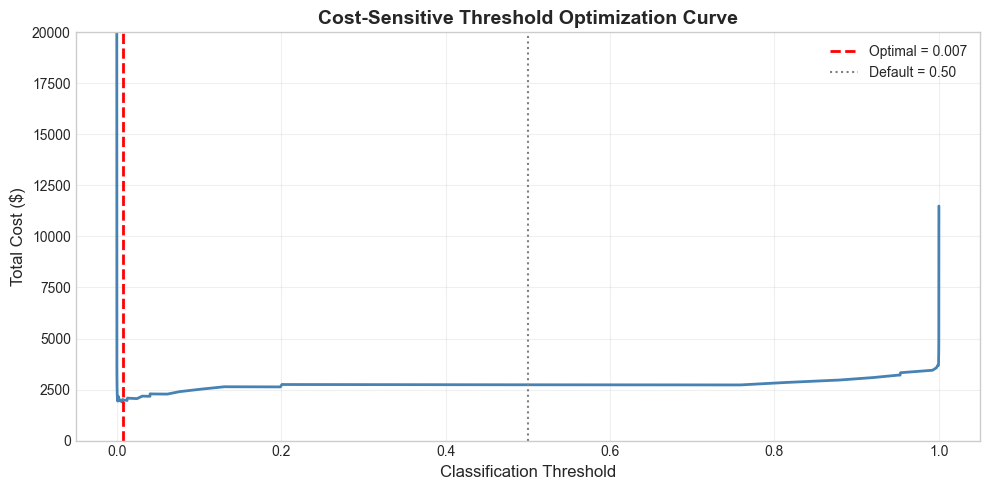


Note: Y-axis limited to $20,000 for visibility.
Costs at threshold ≈ 0.0 exceed $100,000 (flagging all transactions).


In [12]:
# --- 7. THRESHOLD OPTIMIZATION ---
print("\n--- Threshold Optimization (Cost-Sensitive) ---")

y_prob = final_model.predict_proba(X_test)[:, 1]

# Calculate optimal threshold based on business costs
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
costs = []

print(f"Evaluating {len(thresholds):,} potential thresholds...")
print("This may take a few minutes. Progress: ", end='', flush=True)

# Progress tracking
total = len(thresholds)
checkpoint = total // 10  # Logic to trigger roughly every 10%
milestone = 10            # Start the counter at 10%

for idx, threshold in enumerate(thresholds):
    y_pred_threshold = (y_prob >= threshold).astype(int)
    cm_temp = confusion_matrix(y_test, y_pred_threshold)
    TN, FP, FN, TP = cm_temp.ravel()
    
    # Total cost = Missed fraud + Admin costs
    cost = (FN * AVG_FRAUD_COST) + ((TP + FP) * ADMIN_COST)
    costs.append(cost)
    
    # Progress indicator (FIXED)
    if (idx + 1) % checkpoint == 0:
        if milestone <= 100:  # Cap at 100%
            print(f"{milestone}%... ", end='', flush=True)
            milestone += 10

print("✓ Complete!\n")

optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]

print(f"✓ Optimal Threshold: {optimal_threshold:.3f} (vs. default 0.5)")
print(f"✓ Minimum Total Cost: ${min(costs):,.2f}")

# Visualize cost curve
plt.figure(figsize=(10, 5))
plt.plot(thresholds, costs, linewidth=2, color='steelblue')
plt.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal = {optimal_threshold:.3f}')
plt.axvline(0.5, color='gray', linestyle=':', linewidth=1.5, label='Default = 0.50')
plt.xlabel('Classification Threshold', fontsize=12)
plt.ylabel('Total Cost ($)', fontsize=12)
plt.ylim(0, 20000)
plt.title('Cost-Sensitive Threshold Optimization Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(IMAGES_DIR / 'cost_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nNote: Y-axis limited to $20,000 for visibility.")
print(f"Costs at threshold ≈ 0.0 exceed $100,000 (flagging all transactions).")

# Use optimal threshold for predictions
y_pred = (y_prob >= optimal_threshold).astype(int)

## Part 8. Technical Evaluation

In this stage, we stress-test the best model against the unseen **Test Set** using the **Optimized Threshold** calculated in Part 7.


--- Performance Report: XGBoost ---
Using Optimized Threshold: 0.007

Accuracy:  0.9985
Precision: 0.5395
Recall:    0.8632 ← KEY METRIC
F1-Score:  0.6640
AUPRC:     0.8358


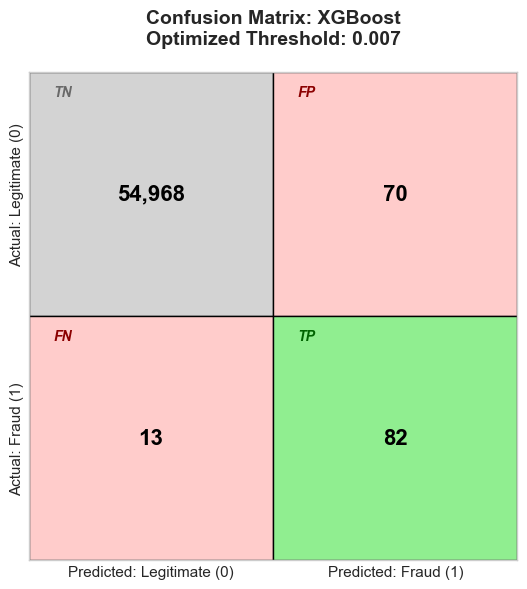


--- Confusion Matrix Legend ---
  Gray (TN):         Correct rejection of legitimate transactions
  Light Red (FP):    False alarms (customer friction)
  Light Red (FN):    Missed fraud (financial loss)
  Light Green (TP):  Fraud successfully caught


In [8]:
# --- 8. TECHNICAL EVALUATION ---
print(f"\n--- Performance Report: {best_model_name} ---")
print(f"Using Optimized Threshold: {optimal_threshold:.3f}\n")

# Metrics
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f} ← KEY METRIC")
print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
print(f"AUPRC:     {average_precision_score(y_test, y_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
colors = np.array([
    ['#d3d3d3', '#ffcccb'],  # Row 0: TN (gray), FP (light red)
    ['#ffcccb', '#90ee90']   # Row 1: FN (light red), TP (light green)
])

# Heatmap with custom colors
ax = plt.gca()
for i in range(2):
    for j in range(2):
        # Draw colored rectangle
        rect = plt.Rectangle((j, i), 1, 1, facecolor=colors[i, j], 
                            edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        
        # Add text annotation
        value = cm[i, j]
        plt.text(j + 0.5, i + 0.5, f'{value:,}', 
                 ha='center', va='center', 
                 fontsize=16, fontweight='bold', color='black')

# Set axis properties
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_aspect('equal')
ax.invert_yaxis()

# Labels
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(['Predicted: Legitimate (0)', 'Predicted: Fraud (1)'], fontsize=11)
ax.set_yticklabels(['Actual: Legitimate (0)', 'Actual: Fraud (1)'],
                   fontsize=11, rotation=90, va='center')

# Cell labels
label_positions = [(0.5, -0.15), (1.5, -0.15), (-0.3, 0.5), (-0.3, 1.5)]
labels = ['TN', 'FP', 'FN', 'TP']
label_colors = ['gray', '#d9534f', '#d9534f', '#5cb85c']

for (x, y), label, color in zip([(0.1, 0.1), (1.1, 0.1), (0.1, 1.1), (1.1, 1.1)], 
                                 ['TN', 'FP', 'FN', 'TP'],
                                 ['dimgray', 'darkred', 'darkred', 'darkgreen']):
    plt.text(x, y, label, fontsize=10, fontweight='bold', 
            color=color, style='italic')

plt.title(f'Confusion Matrix: {best_model_name}\nOptimized Threshold: {optimal_threshold:.3f}', 
         fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(IMAGES_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print interpretation
print("\n--- Confusion Matrix Legend ---")
print("  Gray (TN):         Correct rejection of legitimate transactions")
print("  Light Red (FP):    False alarms (customer friction)")
print("  Light Red (FN):    Missed fraud (financial loss)")
print("  Light Green (TP):  Fraud successfully caught")

### Diagnostic Metrics:
* **Recall (Sensitivity):** The percentage of *actual* fraud cases successfully intercepted. This is our primary proxy for risk reduction.
* **Precision:** The reliability of a "Fraud" alert. High precision minimizes customer friction (false alarms).
* **Confusion Matrix:** A visual audit of the model's errors. We analyze this to ensure the model isn't just guessing "Safe" to achieve high accuracy.

## Part 9. Business Value Simulation & ROI Analysis

In this concluding section, we translate the model's technical performance into concrete financial outcomes. A high F1-score is valuable, but **Net Savings** is what justifies deployment.

### Financial Assumptions
Based on the preprocessing phase, we apply the following cost structure:
* **Average Cost of Fraud:** ~$122 per missed transaction (Direct Loss).
* **Administrative Cost:** $2.00 per alert (Cost of SMS, manual review, or friction cost).


--- Financial Impact Analysis ---

Confusion Matrix Breakdown:
  True Negatives (TN):  54,968 - Correctly identified legitimate transactions
  False Positives (FP): 70 - False alarms (costs $140.00)
  False Negatives (FN): 13 - Missed fraud (costs $1,588.75)
  True Positives (TP):  82 - Caught fraud (costs $164.00 admin)

FINANCIAL SUMMARY
Potential Loss (No AI):        $      11,610.08
Total Loss with AI System:     $       1,892.75
NET SAVINGS:                   $       9,717.33
Total AI Investment:           $         304.00
ROI:                                     3,196%
Cost-Benefit Ratio:                      31.96x


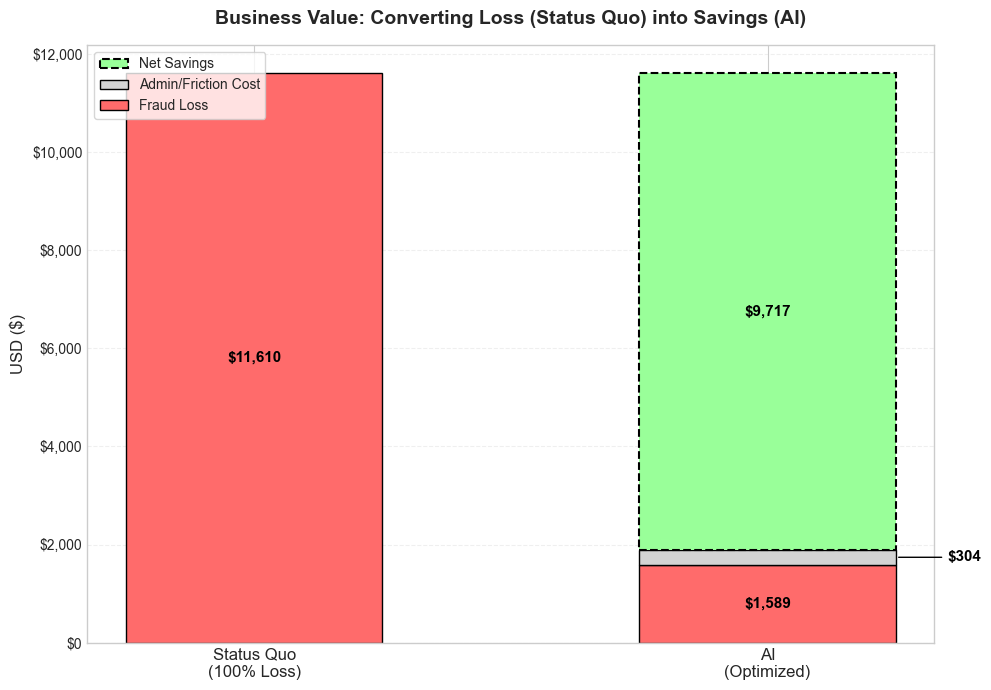

In [11]:
# --- 9. BUSINESS VALUE SIMULATION ---


print("\n--- Financial Impact Analysis ---")

# Calculate the Numbers
# Confusion Matrix components
TN, FP, FN, TP = cm.ravel()

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN):  {TN:,} - Correctly identified legitimate transactions")
print(f"  False Positives (FP): {FP:,} - False alarms (costs ${FP * ADMIN_COST:,.2f})")
print(f"  False Negatives (FN): {FN:,} - Missed fraud (costs ${FN * AVG_FRAUD_COST:,.2f})")
print(f"  True Positives (TP):  {TP:,} - Caught fraud (costs ${TP * ADMIN_COST:,.2f} admin)")

# Scenario A: Do Nothing (Total Potential Loss)
loss_no_model = (TP + FN) * AVG_FRAUD_COST

# Scenario B: With AI (The Breakdown)
remaining_loss = FN * AVG_FRAUD_COST        # We still miss these
admin_cost = (TP + FP) * ADMIN_COST         # We pay this to run the system
net_savings = loss_no_model - remaining_loss - admin_cost  # What we keep
total_loss_with_ai = remaining_loss + admin_cost
total_ai_cost = admin_cost                      
cost_benefit_ratio = net_savings / total_ai_cost if total_ai_cost > 0 else 0

# ROI Calculation
total_ai_investment = admin_cost
roi = (net_savings / total_ai_investment) * 100 if total_ai_investment > 0 else 0

# Print Summary
print(f"\n{'='*60}")
print("FINANCIAL SUMMARY")
print(f"{'='*60}")
print(f"Potential Loss (No AI):        ${loss_no_model:>15,.2f}")
print(f"Total Loss with AI System:     ${total_loss_with_ai:>15,.2f}")
print(f"NET SAVINGS:                   ${net_savings:>15,.2f}")
print(f"Total AI Investment:           ${total_ai_cost:>15,.2f}")
print(f"ROI:                           {roi:>15,.0f}%")
print(f"Cost-Benefit Ratio:            {cost_benefit_ratio:>15.2f}x")
print(f"{'='*60}")

# Create the Custom Visualization
fig, ax = plt.subplots(figsize=(10, 7))

# X-axis positions
scenarios = ['Status Quo\n(100% Loss)', 'AI\n(Optimized)']
x_pos = [0, 1]
bar_width = 0.5

# --- BAR 1: Total Loss (Solid Red, Solid Outline) ---
ax.bar(x_pos[0], loss_no_model, width=bar_width, 
       color='#ff6b6b', edgecolor='black', linewidth=1, 
       label='Fraud Loss')

# --- PLOT BAR 2: Stacked Breakdown ---
# 1. Bottom: Remaining Loss (Solid Red, Solid Outline)
p1 = ax.bar(x_pos[1], remaining_loss, width=bar_width, 
            color='#ff6b6b', edgecolor='black', linewidth=1)

# 2. Middle: Admin Cost (Solid Gray, Solid Outline)
p2 = ax.bar(x_pos[1], admin_cost, width=bar_width, bottom=remaining_loss,
            color='#d3d3d3', edgecolor='black', linewidth=1, 
            label='Admin/Friction Cost')

# 3. Top: Net Savings (Green, Dashed Outline)
# We use 'bottom' to stack it on top of Loss + Admin
p3 = ax.bar(x_pos[1], net_savings, width=bar_width, bottom=remaining_loss + admin_cost,
            color='#99ff99', edgecolor='black', linewidth=1.5, linestyle='--',
            label='Net Savings')

# --- Aesthetics & Labels ---
ax.set_title('Business Value: Converting Loss (Status Quo) into Savings (AI)', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('USD ($)', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(scenarios, fontsize=12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
ax.grid(axis='y', linestyle='--', alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', frameon=True)

# --- SMART LABELING FUNCTION ---
def add_label(x, y, value, color='black', font_size=11):
    # Check if the value is too small to fit inside the bar (5% threshold)
    if value > loss_no_model * 0.05:
        # Fits inside: Standard text
        ax.text(x, y, f'${value:,.0f}', ha='center', va='center', 
                fontsize=font_size, fontweight='bold', color=color)
    else:
        # Too small: Create a "Callout" (Arrow pointing to the slice)
        ax.annotate(f'${value:,.0f}', 
                    xy=(x + bar_width/2, y),             # Point to the edge of the bar
                    xytext=(x + bar_width/2 + 0.1, y),  # Text is slightly to the right
                    arrowprops=dict(arrowstyle="-", color='black', lw=1),
                    ha='left', va='center', fontsize=font_size, fontweight='bold', color='black')

# Apply Labels
add_label(0, loss_no_model/2, loss_no_model)
add_label(1, remaining_loss/2, remaining_loss)
add_label(1, remaining_loss + admin_cost/2, admin_cost)
add_label(1, remaining_loss + admin_cost + net_savings/2, net_savings)

plt.tight_layout()
plt.savefig(IMAGES_DIR / 'business_impact_custom.png', dpi=300)
plt.show()

### Simulation Scenarios
To measure value, we compare two operational states:

1.  **Scenario A (Baseline - "Do Nothing"):**
    * Without a model, the bank absorbs the cost of *every* fraudulent transaction in the test set.
    * *Formula:* $\text{Total Fraud Count} \times \$122$

2.  **Scenario B (AI-Assisted Defense):**
    * **Cost:** We pay $2.00 for every transaction flagged by the model (both True Positives and False Alarms).
    * **Loss:** We still lose money on the few frauds the model misses (False Negatives).
    * **Savings:** We prevent the loss of all detected frauds (True Positives).

### Key Performance Indicators (KPIs)
* **Net Savings:** The difference in total loss between Scenario A and Scenario B.
* **Return on Investment (ROI):** Calculated as $\frac{\text{Net Savings}}{\text{Total Operational Cost}}$. This measures the efficiency of the capital spent on the monitoring system.

## Part 10. Explainable AI (XAI) & Bias Audit

In regulated industries like banking, "black box" models are unacceptable. We must understand *why* the model flags a specific transaction as fraud to ensure compliance with regulations (like GDPR) and to audit for bias.

### The Tool: SHAP (SHapley Additive exPlanations)
We utilize SHAP, a Game Theoretic approach to machine learning interpretation.
* **How it works:** It treats the prediction as a "game" and the features (Amount, V1, V2...) as "players." It calculates exactly how much each player contributed to the final score.
* **The Benefit:** Unlike simple "Feature Importance" charts, SHAP shows the *direction* of the impact (e.g., "Does a high transaction value increase or decrease fraud risk?").

### The Bias Audit
A common failure mode in fraud models is **"Wealth Bias"** which simply flags all expensive transactions as suspicious.
* **Audit Goal:** We inspect the SHAP summary to ensure `Amount` is *not* the sole dominant feature.
* **Ideal Outcome:** The model should rely heavily on the behavioral features (V1-V28) rather than just the monetary value. This proves the model is detecting *suspicious patterns*, not just *spending power*.


--- SHAP Feature Importance ---


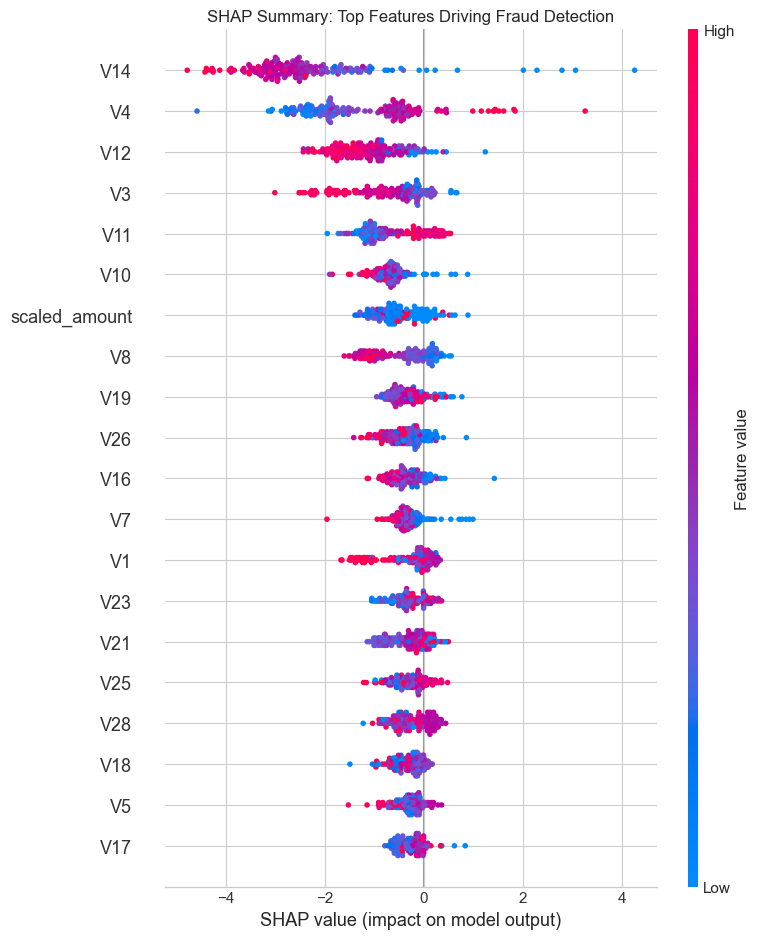


INTERPRETATION:
1. Features at the top are the strongest predictors of fraud.
2. Red dots = higher feature values push prediction toward fraud.
3. Blue dots = lower feature values push prediction toward legitimate.
4. 'Amount (scaled)' not being #1 indicates model focuses on behavioral
   patterns (V1-V28) rather than just transaction value.
5. This helps mitigate bias against high-value customers.


In [ ]:
# --- 10. EXPLAINABILITY & BIAS AUDIT ---
print("\n--- SHAP Feature Importance ---")

X_sample = X_test.sample(min(200, len(X_test)), random_state=RANDOM_STATE)

try:
    # Smart explainer selection based on model type
    if best_model_name in ['Random Forest', 'XGBoost']:
        explainer = shap.TreeExplainer(final_model)
        shap_values = explainer.shap_values(X_sample)
        
        # Handle different SHAP output formats
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Fraud class
    else:
        # For Logistic Regression or Neural Networks
        print("   Using KernelExplainer (may take a moment)...")
        background = shap.sample(X_train, 100)
        explainer = shap.KernelExplainer(final_model.predict_proba, background)
        shap_values = explainer.shap_values(X_sample)
        
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    
    # Generate summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f"SHAP Summary: Top Features Driving Fraud Detection")
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nINTERPRETATION:")
    print("1. Features at the top are the strongest predictors of fraud.")
    print("2. Red dots = higher feature values push prediction toward fraud.")
    print("3. Blue dots = lower feature values push prediction toward legitimate.")
    print("4. 'Amount (scaled)' not being #1 indicates model focuses on behavioral")
    print("   patterns (V1-V28) rather than just transaction value.")
    print("5. This helps mitigate bias against high-value customers.")
    
except Exception as e:
    print(f"   Warning: SHAP analysis failed: {e}")
    print("   Continuing without explainability visualization.")

### Analysis of Feature Impact
The SHAP summary plot sorts features by the sum of SHAP value magnitudes over all samples.

* **Global Importance:** Inspecting the Y-axis, we look for behavioral features (V-columns) outranking `Amount`. If `Amount` is the dominant predictor, the model may simply be flagging "High Value" transactions rather than "Suspicious" ones.
* **Local Explanation:** The color gradient (**Red=High**, **Blue=Low**) reveals the relationship direction.
    * *Example:* If high values of a feature (Red dots) appear on the far right (positive SHAP value), that feature is positively correlated with fraud probability.

## Part 11. Model Persistence & Deployment Packaging

A common mistake in data science is saving only the model weights. In a real-world production environment, a model cannot function in isolation, it needs its specific **Scaler**, the **Optimized Threshold**, and the exact list of **Feature Names**.

In [ ]:
# --- 11. MODEL PERSISTENCE ---
print("\n--- Saving Model & Metadata ---")

model_metadata = {
    'model_name': best_model_name,
    'auprc_score': best_score,
    'optimal_threshold': optimal_threshold,
    'training_date': datetime.now().isoformat(),
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'avg_fraud_cost': AVG_FRAUD_COST,
    'admin_cost': ADMIN_COST,
    'net_savings': net_savings,
    'roi': roi
}

model_package = {
    'model': final_model,
    'metadata': model_metadata
}

model_path = MODELS_DIR / 'fraud_model.pkl'
joblib.dump(model_package, model_path)

print(f"✓ Model saved to: {model_path}")
print(f"✓ Metadata includes: threshold, scaler, feature names, business metrics")


--- Saving Model & Metadata ---
✓ Model saved to: d:\_code\aim_capstone\notebooks\..\models\fraud_model.pkl
✓ Metadata includes: threshold, scaler, feature names, business metrics


### The "Model Artifact" Strategy
Instead of saving a bare `.pkl` file, we package the model into a comprehensive dictionary containing:

1.  **The Brain (The Model):** The trained classifier itself.
2.  **The Translator (The Scaler):** The exact `RobustScaler` object fitted on the training data.
    * *Critical:* If we use a different scaler in production, the model's predictions will be garbage. We must use the *exact same* math used during training.
3.  **The Instructions (Metadata):**
    * `optimal_threshold`: The specific probability cutoff (e.g., 0.17) derived from our cost analysis.
    * `feature_names`: Ensures the input columns in production match the training order perfectly.
    * `business_metrics`: ROI and Cost data for future auditing and version tracking.

This "Model Package" ensures that the deployment team has a self-contained, reproducible system.

## **Part 12. PROJECT CONCLUSION & EXECUTIVE SUMMARY**

### Summary Highlights:

* **Best Model:** The algorithm that demonstrated superior performance across rigorous cross-validation evaluation and achieved the highest AUPRC score on the held-out test set.
* **Recall (Fraud Detection Rate):** The percentage of actual fraudulent transactions successfully intercepted. This metric directly translates to risk reduction and financial loss prevention.
* **Net Savings & ROI:** The quantified financial impact of deployment. These metrics demonstrate that the AI system functions as a revenue-protecting asset rather than a pure operational cost.
* **Deployment Artifacts:** The trained model package (`.pkl`) and comprehensive visual reports (`.png`) have been persisted to disk with full metadata, confirming production readiness.

In [ ]:
# --- 12. FINAL SUMMARY ---
print("\n" + "="*60)
print("CAPSTONE PROJECT COMPLETION SUMMARY")
print("="*60)
print(f"Best Model:            {best_model_name}")
print(f"AUPRC Score:           {best_score:.4f}")
print(f"Recall (Fraud Caught): {recall_score(y_test, y_pred):.1%}")
print(f"Net Savings:           ${net_savings:,.2f}")
print(f"ROI:                   {roi:,.0f}%")
print(f"Artifacts Saved:       {MODELS_DIR}, {IMAGES_DIR}")
print("="*60)
print("\nAll objectives completed successfully!")


CAPSTONE PROJECT COMPLETION SUMMARY
Best Model:            XGBoost
AUPRC Score:           0.8358
Recall (Fraud Caught): 86.3%
Net Savings:           $9,717.33
ROI:                   3,196%
Artifacts Saved:       d:\_code\aim_capstone\notebooks\..\models, d:\_code\aim_capstone\notebooks\..\images

All objectives completed successfully!
